In [1]:
import os
import random
import numpy as np
# from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

import train
import model
import utils
import gmm

data_dir =  '../data'
model_dir = '../log/SXmodel1030-1013'

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






In [3]:
# load dataset and paramters
[train_set, valid_set, test_set, std_train_set, std_valid_set, std_test_set, 
     hps_model, eval_hps_model] = train.load_env(data_dir, model_dir)

Dataset combined: 3731 (train=2000/validate=1000/test=731)
model_params.max_seq_len set to 68.


In [4]:
# construct model:
train.reset_graph()
train_model = model.FontRNN(hps_model)
eval_model = model.FontRNN(eval_hps_model, reuse=True)





Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

INFO:tensorflow:Model using LuongMonotonicAttention.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.cast` instead.



INFO:tensorflow:Model using LuongMonotonicAttention.
ERROR:

In [5]:
# load trained checkpoint
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train.load_checkpoint(sess, model_dir)



Loading model ../log/SXmodel1030-1013/vector-8200.
INFO:tensorflow:Restoring parameters from ../log/SXmodel1030-1013/vector-8200


In [9]:
def test_model(sess, testmodel, input_stroke):
    stroke_len = len(input_stroke)
    input_stroke = utils.to_big_strokes(input_stroke, max_len=testmodel.hps.max_seq_len).tolist()
    input_stroke.insert(0, [0, 0, 1, 0, 0])
    feed = {testmodel.enc_input_data: [input_stroke],
            testmodel.enc_seq_lens: [stroke_len],
            }
    output = sess.run([testmodel.pi, testmodel.mu1, testmodel.mu2, testmodel.sigma1,
                       testmodel.sigma2, testmodel.corr, testmodel.pen,
                       testmodel.timemajor_alignment_history],
                      feed)
    gmm_params = output[:-1]
    timemajor_alignment_history = output[7]

    return gmm_params, timemajor_alignment_history


def sample_from_params(params, temp=0.1, greedy=False):
    [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen] = params

    max_len = o_pi.shape[0]
    num_mixture = o_pi.shape[1]

    strokes = np.zeros((max_len, 5), dtype=np.float32)

    for step in range(max_len):
        next_x1 = 0
        next_x2 = 0
        eos = [0, 0, 0]
        eos[np.argmax(o_pen[step])] = 1
        for mixture in range(num_mixture):
            x1, x2 = gmm.sample_gaussian_2d(o_mu1[step][mixture], o_mu2[step][mixture],
                                            o_sigma1[step][mixture], o_sigma2[step][mixture],
                                            o_corr[step][mixture], np.sqrt(temp), greedy)
            next_x1 += x1 * o_pi[step][mixture]
            next_x2 += x2 * o_pi[step][mixture]
        strokes[step, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
    strokes = utils.to_normal_strokes(strokes)
    return strokes

def to_absolute_coordinate(mat, scale_factor=300):
    low_tri_matrix = np.tril(np.ones((mat.shape[0], mat.shape[0])), 0)
    mat[:, :2] = np.rint(scale_factor * np.matmul(low_tri_matrix, mat[:, :2]))
    return mat

def sub_draw(mat, count_lim):
    cnt = pre_i = 0
    xmax, xmin = np.max(mat[:, 0]), np.min(mat[:, 0])
    ymax, ymin = np.max(mat[:, 1]), np.min(mat[:, 1])
    for i in range(mat.shape[0]):
        if mat[i][2] == 1:
            plt.plot(
                mat[pre_i:i + 1, 0],
                mat[pre_i:i + 1, 1],
                linewidth=3)
            cnt += 1
            pre_i = i + 1
            if cnt >= count_lim:
                break
    # plt.axis('off')
    # plt.hlines(ylim / 2, 0, xlim)
    # plt.vlines(xlim / 2, 0, ylim)
    plt.xlim((xmin - 10, xmax + 10))
    plt.ylim((ymin - 10, ymax + 10))
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    # plt.title("Groud Truth")

def draw_grid(mat1_list, mat2_list, mat3_list, draw_count_lim):
    def to_abs_list(mat_list):
        return [to_absolute_coordinate(mat.copy()) for mat in mat_list]

    mat1_list, mat2_list, mat3_list = [to_abs_list(i) for i in (mat1_list, mat2_list, mat3_list)]

    width = max(len(m) for m in (mat1_list, mat2_list, mat3_list))
    
    plt.figure(figsize=(3 * width, 9))
    for i in range(width):
        plt.subplot(3, width, 1 + i)
        sub_draw(mat1_list[i], draw_count_lim)
        
        plt.subplot(3, width, 1 + i + width)
        sub_draw(mat2_list[i], draw_count_lim)
        
        plt.subplot(3, width, 1 + i + width * 2)
        sub_draw(mat3_list[i], draw_count_lim)

In [10]:
def draw_by_index_list(index_list, draw_count_lim=10000):
    list1, list2, list3 = [], [], []
    for index in index_list:
        from_strokes = np.copy(std_test_set.strokes[index])
        to_strokes = np.copy(test_set.strokes[index])
        params, timemajor_alignment_history = test_model(sess, eval_model, from_strokes)
        generated_strokes = sample_from_params(params, greedy=True)
        list1.append(from_strokes)
        list2.append(to_strokes)
        list3.append(generated_strokes)
    draw_grid(list1, list2, list3, draw_count_lim)

[ 21 405 420 306 261 679 640 328  36 390]


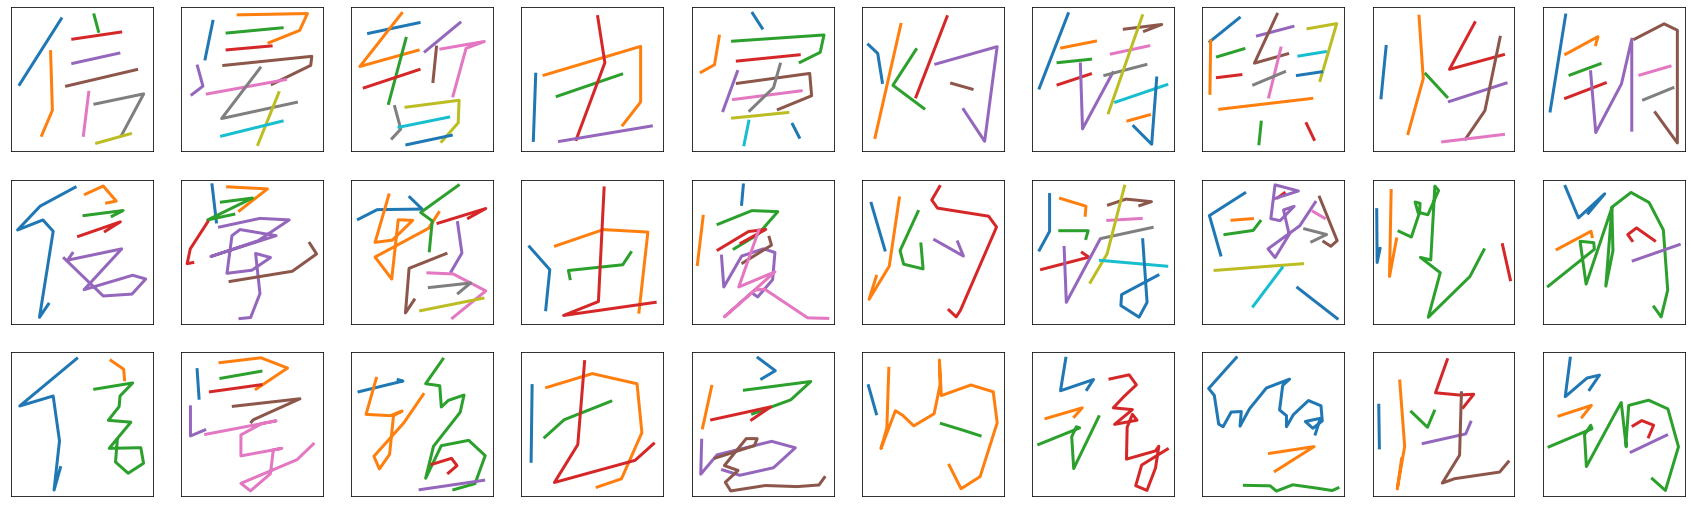

In [38]:
total_count = test_set.strokes.shape[0]
index_list = np.random.choice(total_count, 10)
print(index_list)
draw_by_index_list(index_list)

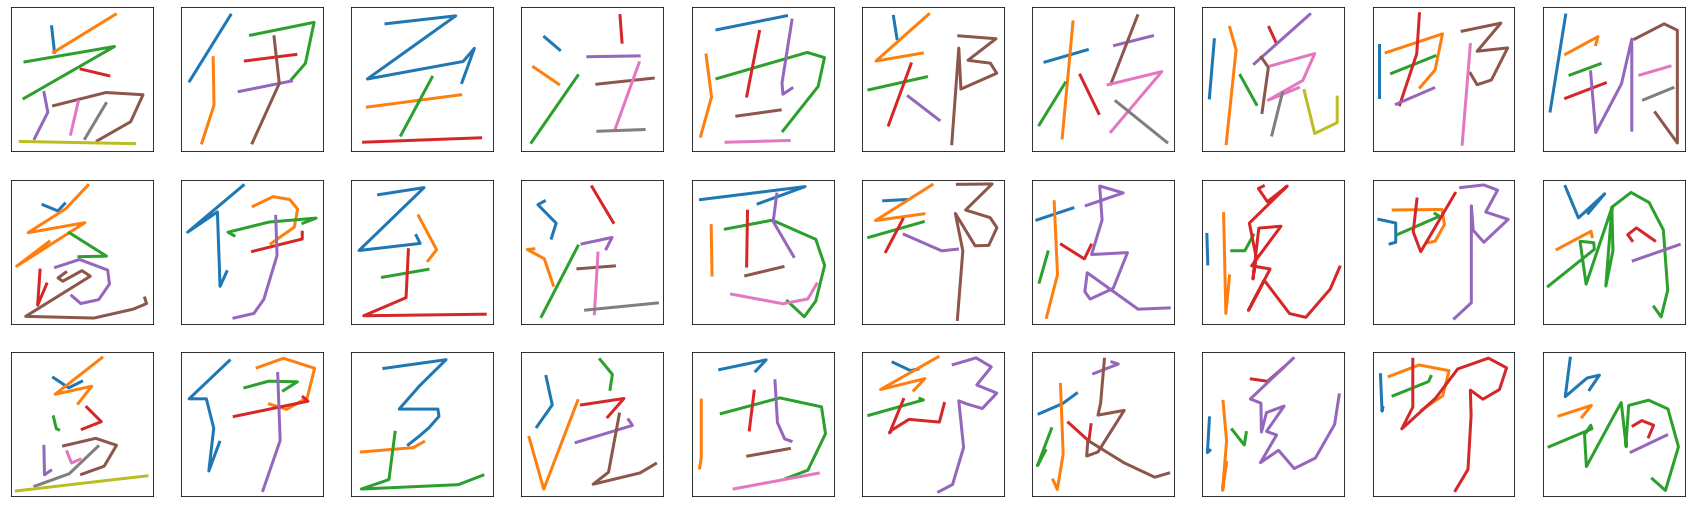

In [39]:
valid_index = [241, 204, 580, 643, 312, 550, 553, 394, 307, 390]
draw_by_index_list(valid_index)

In [18]:
data = np.load("../data/1030-1013-c-tag.npz")

In [22]:
tag_list = data["tag"]

In [23]:
word2idx = {w : i for i, w in enumerate(tag_list)}

In [24]:
s = "花开堪折直须折"
idx_list = [word2idx[w] for w in s]

In [25]:
draw_by_index_list(idx_list)

IndexError: index 1036 is out of bounds for axis 0 with size 731

In [190]:
import io
from PIL import Image

images = []
total_count = test_set.strokes.shape[0]
index_list = np.random.choice(total_count, 10)
for i in range(20):
    draw_by_index_list(index_list, i)
    buff = io.BytesIO()
    plt.savefig(buff, format="png")
    plt.close()
    im = Image.open(buff)
    # im.show()
    images.append(im)

images[0].save("writer.gif",
               format="GIF",
               save_all=True,
               append_images=images[1:],
               duration=400,
               loop=0)

In [216]:
def order_draw(index):
    from_strokes = np.copy(std_test_set.strokes[index])
    to_strokes = np.copy(test_set.strokes[index])
    params, timemajor_alignment_history = test_model(sess, eval_model, from_strokes)
    generated_strokes = sample_from_params(params, greedy=True)

    mats = (from_strokes, to_strokes, generated_strokes)
    mats = [to_absolute_coordinate(mat.copy()) for mat in mats]
    count_lim = max(int(np.sum(mat[:, 2])) for mat in mats)

    plt.figure(figsize=(3 * count_lim, 9))
    for i in range(count_lim):
        plt.subplot(3, count_lim, 1 + i)
        sub_draw(mats[0], i + 1)

        plt.subplot(3, count_lim, 1 + i + count_lim)
        sub_draw(mats[1], i + 1)

        plt.subplot(3, count_lim, 1 + i + count_lim * 2)
        sub_draw(mats[2], i + 1)

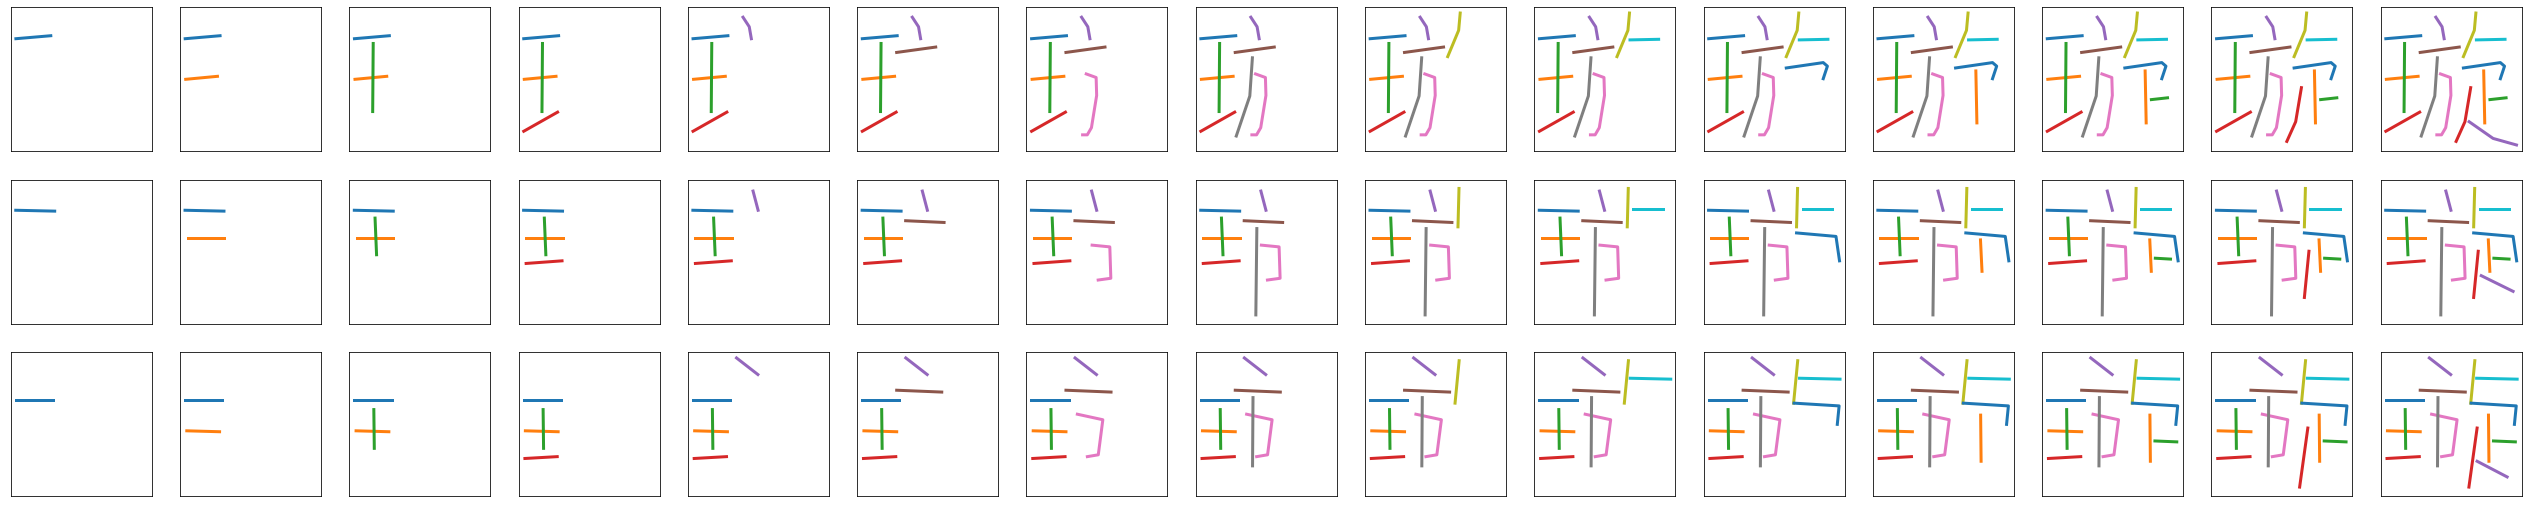

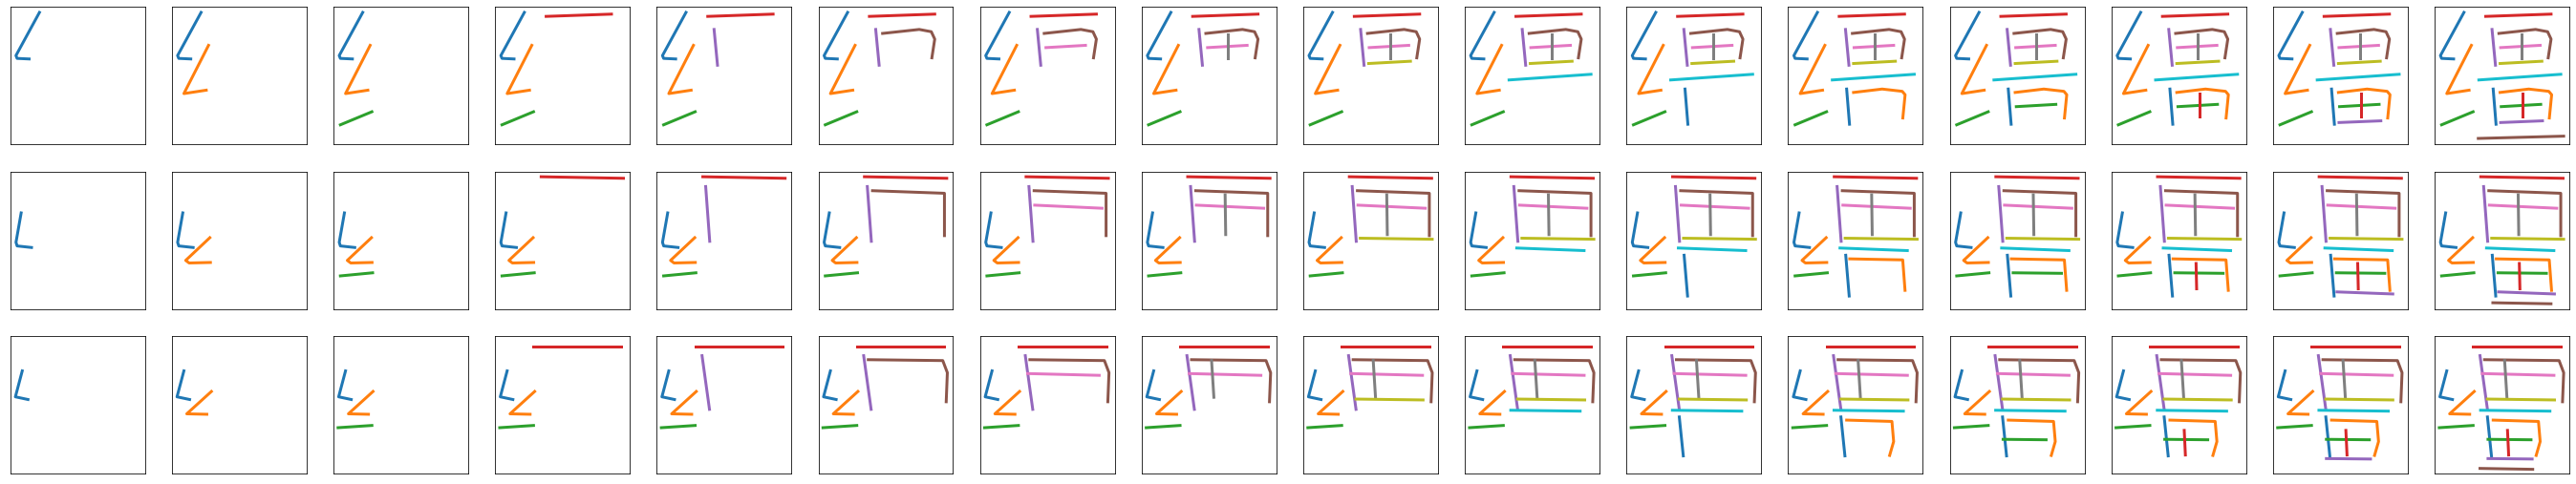

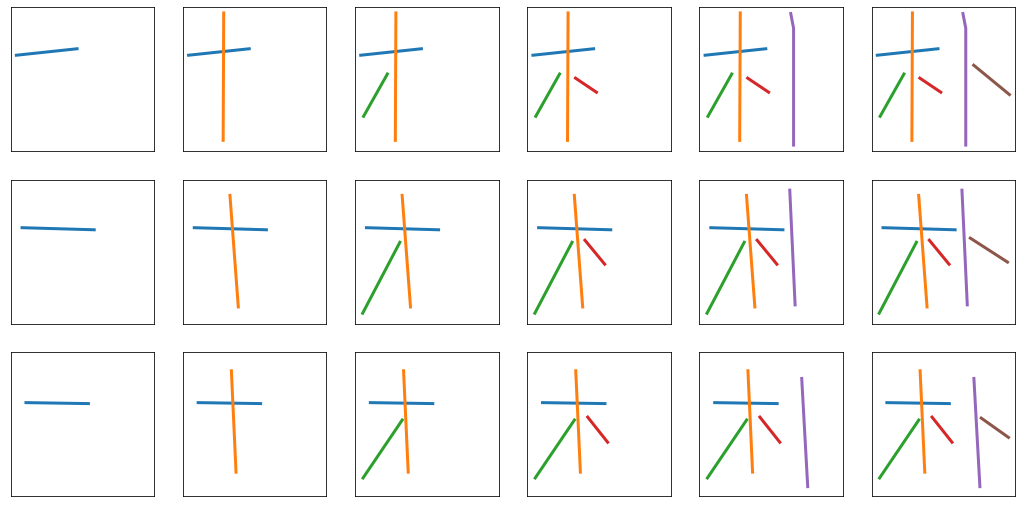

In [223]:
index_list = np.random.choice(total_count, 3)
for index in index_list:
    order_draw(index)